In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [61]:
import torch

In [62]:
PATH = "data/dog-breed-identification/"
sz=224
arch=resnet34
bs=58

In [14]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [15]:
val_idxs

array([2882, 4514, 7717, ..., 8922, 6774,   37])

In [16]:
n

10222

In [17]:
len(val_idxs)

2044

In [18]:
??get_cv_idxs

In [19]:
!ls {PATH}

labels.csv	sample_submission.csv	   test      train
labels.csv.zip	sample_submission.csv.zip  test.zip  train.zip


In [20]:
label_df = pd.read_csv(label_csv)

In [21]:
label_df.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [22]:
label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)[:10]

id
breed                    
scottish_deerhound    126
maltese_dog           117
afghan_hound          116
entlebucher           115
bernese_mountain_dog  114
shih-tzu              112
great_pyrenees        111
pomeranian            111
basenji               110
samoyed               109

In [24]:
??tfms_from_model

In [25]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)

In [30]:
fn = PATH + data.trn_ds.fnames[2]; fn

'data/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg'

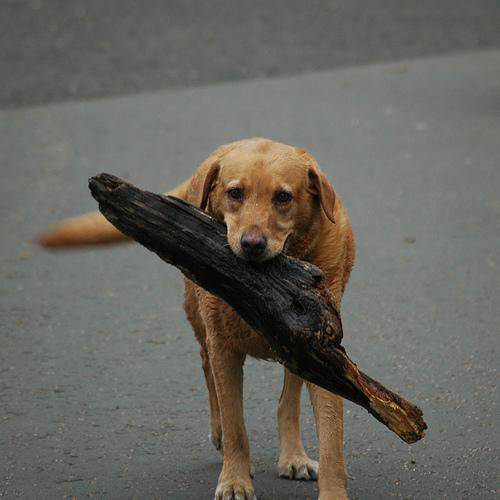

In [31]:
img = PIL.Image.open(fn); img

In [32]:
img.size

(500, 500)

In [33]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [34]:
row_sz, col_sz = list(zip(*size_d.values()))

In [35]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [37]:
row_sz[:20]

array([500, 500, 500, 500, 500, 231, 500, 402, 250, 200, 374, 333, 500, 390, 400, 200, 500, 375, 500, 300])

(array([3023., 5024.,   92.,   15.,    5.,    3.,   13.,    2.,    0.,    1.]),
 array([  97. ,  413.7,  730.4, 1047.1, 1363.8, 1680.5, 1997.2, 2313.9, 2630.6, 2947.3, 3264. ]),
 <a list of 10 Patch objects>)

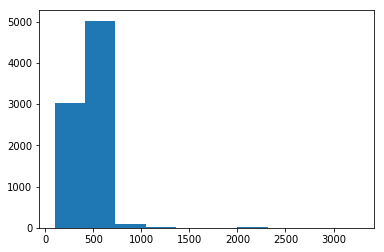

In [38]:
plt.hist(row_sz)

(array([ 135.,  592., 1347., 1164., 4599.,  128.,   76.,   62.,   14.,   11.]),
 array([ 97. , 185.5, 274. , 362.5, 451. , 539.5, 628. , 716.5, 805. , 893.5, 982. ]),
 <a list of 10 Patch objects>)

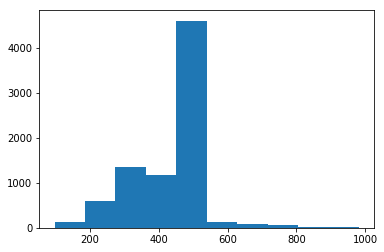

In [39]:
plt.hist(row_sz[row_sz<1000])

(array([2870., 5121.,  128.,   25.,   10.,   15.,    5.,    2.,    0.,    2.]),
 array([ 102.,  348.,  594.,  840., 1086., 1332., 1578., 1824., 2070., 2316., 2562.]),
 <a list of 10 Patch objects>)

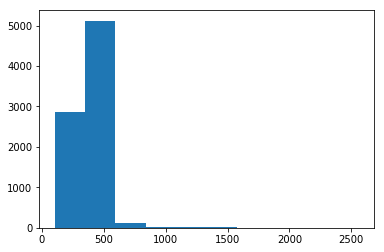

In [40]:
plt.hist(col_sz)

(array([ 235.,  733., 2205., 2979., 1807.,   98.,   27.,   33.,    7.,   10.]),
 array([102., 190., 278., 366., 454., 542., 630., 718., 806., 894., 982.]),
 <a list of 10 Patch objects>)

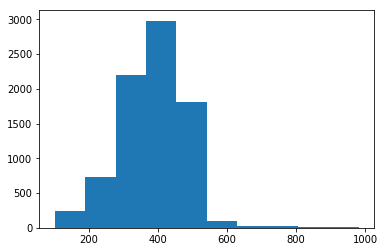

In [41]:
plt.hist(col_sz[col_sz<1000])

In [42]:
len(data.trn_ds), len(data.test_ds)

(8178, 10357)

In [43]:
len(data.classes), data.classes[:5]

(120,
 ['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier'])

In [50]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    return data if sz > 300 else data.resize(340, 'tmp')

In [51]:
!ls {PATH}

labels.csv	sample_submission.csv	   test      tmp    train.zip
labels.csv.zip	sample_submission.csv.zip  test.zip  train


In [52]:
data = get_data(sz, bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [53]:
??tfms_from_model

In [55]:
??ImageClassifierData

In [63]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

100%|██████████| 179/179 [00:24<00:00,  7.45it/s]


In [64]:
??resnet34

In [65]:
learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      2.539184   1.245354   0.748905  
    1      1.342715   0.750479   0.810208                    



[0.75047946, 0.8102079977591833]

In [66]:
learn.precompute = False
learn.fit(1e-2, 5, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.104838   0.664937   0.817323  
    1      1.016164   0.615066   0.817323                   
    2      0.930852   0.575317   0.829776                    
    3      0.900826   0.555563   0.832239                    
    4      0.836964   0.541098   0.833197                    



[0.54109776, 0.8331965009371439]

In [67]:
log_preds, y = learn.TTA()
probs = np.exp(log_preds)
accuracy(log_preds, y), metrics.log_loss(y, probs)

TypeError: torch.max received an invalid combination of arguments - got (numpy.ndarray, dim=int), but expected one of:
 * (torch.FloatTensor source)
 * (torch.FloatTensor source, torch.FloatTensor other)
      didn't match because some of the keywords were incorrect: dim
 * (torch.FloatTensor source, int dim)
 * (torch.FloatTensor source, int dim, bool keepdim)
